# Imitation learning training script!!!!

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pandas as pd
import numpy as np
import pathlib

import random
import time

import matplotlib.pyplot as plt

import cv2

## Check if CUDA is available

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Data loader

In [6]:
max_x = 2.5
max_z = 5.0

In [7]:
# Load all sessions and combine into a single pool
base_path = pathlib.Path("/home/kazuh/Documents/UBC/ENPH_353/training_data/all_sessions")
session_dirs = sorted([d for d in base_path.iterdir() if d.is_dir()])

all_img_paths = []
all_x_vals = []
all_z_vals = []

print("Loading data from all sessions...")
for session_dir in session_dirs:
    labels_path = session_dir / "labels.csv"
    df = pd.read_csv(labels_path, header=None, skiprows=1)
    
    for _, row in df.iterrows():
        img_path = session_dir / row[0]
        all_img_paths.append(img_path)
        all_x_vals.append(row[1] / max_x)
        all_z_vals.append(row[2] / max_z)

print(f"Total samples loaded: {len(all_img_paths)}")

# Convert to numpy arrays
all_x_vals = np.array(all_x_vals)
all_z_vals = np.array(all_z_vals)

# Randomize the order
indices = np.arange(len(all_img_paths))
np.random.shuffle(indices)

all_img_paths = [all_img_paths[i] for i in indices]
all_x_vals = all_x_vals[indices]
all_z_vals = all_z_vals[indices]

# Split into train and validation sets (80/20 split)
split_idx = int(0.8 * len(all_img_paths))

train_img_paths = all_img_paths[:split_idx]
train_x_vals = all_x_vals[:split_idx]
train_z_vals = all_z_vals[:split_idx]

val_img_paths = all_img_paths[split_idx:]
val_x_vals = all_x_vals[split_idx:]
val_z_vals = all_z_vals[split_idx:]

print(f"Training samples: {len(train_img_paths)}")
print(f"Validation samples: {len(val_img_paths)}")

Loading data from all sessions...
Total samples loaded: 13388
Training samples: 10710
Validation samples: 2678
Total samples loaded: 13388
Training samples: 10710
Validation samples: 2678


In [8]:
class DrivingDataset(torch.utils.data.Dataset):

    def __init__(self, img_paths, x_vals, z_vals):
        self.img_paths = img_paths
        self.x_vals = x_vals
        self.z_vals = z_vals

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = str(self.img_paths[idx])

        img = cv2.imread(img_path)
        if img is None:
            raise RuntimeError(f"Could not load image: {img_path}")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.0
        img = np.transpose(img, (2, 0, 1))  # (H,W,C)->(C,H,W)

        x = np.array([self.x_vals[idx], self.z_vals[idx]], dtype=np.float32)

        return torch.tensor(img), torch.tensor(x)


In [9]:
batch_size = 32

train_dataset = DrivingDataset(train_img_paths, train_x_vals, train_z_vals)
val_dataset   = DrivingDataset(val_img_paths, val_x_vals, val_z_vals)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True
)


## Design Model

In [10]:
class JackDrivingModel(nn.Module):

    def __init__(self, img_channels = 3, img_h = 600, img_w = 800, act_dim = 2):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(img_channels, 24, kernel_size=5, stride=2), nn.ReLU(),
            nn.Conv2d(24, 36, kernel_size=5, stride=2), nn.ReLU(),
            nn.Conv2d(36, 48, kernel_size=5, stride=2), nn.ReLU(),
            nn.Conv2d(48, 64, kernel_size=3, stride=1), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1), nn.ReLU()
        )

        with torch.no_grad():
            dummy = torch.zeros(1, img_channels, img_h, img_w)
            conv_out = self.conv(dummy)
            conv_feat_dim = conv_out.view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(conv_feat_dim, 100), nn.ReLU(),
            nn.Linear(100, 50), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(50, act_dim)  # [vx, wz]
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

        

In [11]:
def reset_model_weights(model):
    """
    Reinitializes all model parameters by calling reset_parameters()
    for each layer that implements it (Conv, Linear, etc.).
    """
    for layer in model.modules():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()


## Training

In [12]:
model = JackDrivingModel(img_channels=3, img_h=600, img_w=800, act_dim=2)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [13]:
reset_model_weights(model)

In [14]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for imgs, targets in loader:
        imgs = imgs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    return running_loss / len(loader.dataset)


In [15]:
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for imgs, targets in loader:
            imgs = imgs.to(device)
            targets = targets.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * imgs.size(0)

    return running_loss / len(loader.dataset)


In [16]:
def train(num_epochs):

    train_loss_history = []
    val_loss_history = []

    best_val_loss = float("inf")

    scheduler = ReduceLROnPlateau(optimizer=optimizer, mode = "min", patience=5, factor=0.5)

    for epoch in range(num_epochs):
        t0 = time.time()

        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss = validate(model, val_loader, criterion, device)

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
    
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} "
              f"| Time: {time.time() - t0:.1f}s "
              f"| Train Loss: {train_loss:.4f} "
              f"| Val Loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Val Loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()


Epoch 1/20 | Time: 32.8s | Train Loss: 0.0655 | Val Loss: 0.0296
Epoch 2/20 | Time: 32.7s | Train Loss: 0.0396 | Val Loss: 0.0198
Epoch 2/20 | Time: 32.7s | Train Loss: 0.0396 | Val Loss: 0.0198
Epoch 3/20 | Time: 32.2s | Train Loss: 0.0304 | Val Loss: 0.0139
Epoch 3/20 | Time: 32.2s | Train Loss: 0.0304 | Val Loss: 0.0139
Epoch 4/20 | Time: 32.5s | Train Loss: 0.0262 | Val Loss: 0.0138
Epoch 4/20 | Time: 32.5s | Train Loss: 0.0262 | Val Loss: 0.0138
Epoch 5/20 | Time: 32.3s | Train Loss: 0.0235 | Val Loss: 0.0115
Epoch 5/20 | Time: 32.3s | Train Loss: 0.0235 | Val Loss: 0.0115
Epoch 6/20 | Time: 32.3s | Train Loss: 0.0222 | Val Loss: 0.0119
Epoch 6/20 | Time: 32.3s | Train Loss: 0.0222 | Val Loss: 0.0119
Epoch 7/20 | Time: 32.3s | Train Loss: 0.0204 | Val Loss: 0.0099
Epoch 7/20 | Time: 32.3s | Train Loss: 0.0204 | Val Loss: 0.0099
Epoch 8/20 | Time: 32.4s | Train Loss: 0.0189 | Val Loss: 0.0103
Epoch 8/20 | Time: 32.4s | Train Loss: 0.0189 | Val Loss: 0.0103
Epoch 9/20 | Time: 32.3s 

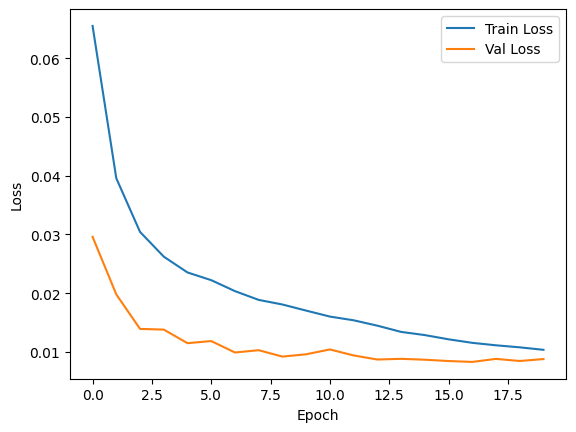

In [17]:
if __name__ == '__main__':
    train(20)


# Convert to PT

In [18]:
model_export = JackDrivingModel(img_channels=3, img_h=600, img_w=800, act_dim=2)

state = torch.load("/home/kazuh/Documents/UBC/ENPH_353/training_data/model_making/11_28_morning.pth")
model_export.load_state_dict(state)

model_export.eval()
scripted_model = torch.jit.script(model_export)

scripted_model.save("11_28_morning.pt")